In [1]:
import os
from pathlib import Path
from typing import List, Optional
from collections import defaultdict


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Hack the system path a little bit so we can import ..scripts.utils
from cs285.scripts import utils

/home/jeffrey/srn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jeffrey/srn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jeffrey/srn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jeffrey/srn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWa

In [2]:
OUTPUT_DIR = Path("../output")
DATA_DIR = Path("../data")

# Helper functions

In [8]:
# Path functions
def get_subdirs(d: Path) -> List[Path]:
    return [f for f in d.iterdir() if f.is_dir()]

def get_exp_paths(exp_name: str, *, most_recent=False) -> List[Path]:
    paths = DATA_DIR.glob(f"*{exp_name}*")
    paths = list(sorted(paths, key=os.path.getmtime, reverse=True))
    paths = [p for p in paths if 'bl' not in str(p)]
    #print(paths)
    #print(exp_name)
    if most_recent:
        return [paths[0]]
    return paths

In [4]:
# Log functions

# https://github.com/franklinfrank/285project/blob/diff_ac/cs285/infrastructure/rl_trainer.py#L278-L301
def parse_tf_eventsfile(filename: str, *, tag='Eval_AverageReturn') -> List:
    eval_returns = []
    for e in tf.train.summary_iterator(filename):
        for v in e.summary.value:
            if v.tag == tag:
                eval_returns.append(v.simple_value)

    return eval_returns

# Plotting Code

In [5]:
DEFAULT_FIGSIZE = (10,8)

TEXT_SIZE_SML = 12
TEXT_SIZE_MED = 18
TEXT_SIZE_LRG = 25

FREE_VARIABLES = {
    'env_sweep': 'env_name', 
    'sample_sweep': 'sample_strategy',
    'terminal_val_sweep': 'terminal_val',
    'batch_size_sweep': 'batch_size'
}

PRETTY_TITLES = {
    'env_sweep': 'Comparison of methods on {env_name}', 
    'sample_sweep': 'Different sample strategies on {env_name}',
    'terminal_val_sweep': 'Different terminal values on {env_name}',
    'batch_size_sweep': 'Different batch size on {env_name}'
}

# BASELINES[env_name][seed]
BASELINES = {
    'CartPole-v0': {
        2020: 'ac_bl_seed=2020_env_name=CartPole-v0_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_CartPole-v0_16-12-2019_13-56-50',
        285: 'ac_bl_seed=285_env_name=CartPole-v0_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_CartPole-v0_16-12-2019_13-56-50',
        2: 'ac_bl_seed=2_env_name=CartPole-v0_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_CartPole-v0_16-12-2019_13-56-50'
        
    },
    'HalfCheetah-v2': {
        2020: 'ac_bl_seed=2020_env_name=HalfCheetah-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_HalfCheetah-v2_16-12-2019_13-56-50',
        285: 'ac_bl_seed=285_env_name=HalfCheetah-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_HalfCheetah-v2_16-12-2019_13-56-49',
        2: 'ac_bl_seed=2_env_name=HalfCheetah-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_HalfCheetah-v2_16-12-2019_13-56-50'
    },
    'InvertedPendulum-v2': {
        2020: 'ac_bl_seed=2020_env_name=InvertedPendulum-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_InvertedPendulum-v2_16-12-2019_13-56-50',
        285: 'ac_bl_seed=285_env_name=InvertedPendulum-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_InvertedPendulum-v2_16-12-2019_13-56-50',
        2: 'ac_bl_seed=2_env_name=InvertedPendulum-v2_sample_strategy=ordered_random_terminal_val=2_batch_size=4000_InvertedPendulum-v2_16-12-2019_13-56-50'
    }
}

In [13]:
def plot_exp_set(exp_set_name: str, *, plot_baseline=False) -> None:
    """ Always averages over seeds
    """ 
    
    # Create a figure for each environment
    for i, env_name in enumerate(utils.environments):
        title = PRETTY_TITLES[exp_set_name].format(env_name=env_name)
        plt.figure(i, figsize=DEFAULT_FIGSIZE)
        plt.title(title)
    
    logfiles = defaultdict(lambda: defaultdict(list))
    tmp = utils.get_exp_flags(exp_set_name)
    for exp_flags in tmp:
        # Get the run_folder for this combination of experiment flags
        exp_name = utils.get_exp_name(exp_flags)
        #print(exp_name)
        run_folder = get_exp_paths(exp_name, most_recent=True)[0]
        # Identify the logfile
        logfile = str(list(run_folder.iterdir())[0])
        
        # Average over seed, so get a exp_name that excludes the seed
        exp_label = exp_flags[FREE_VARIABLES[exp_set_name]] if exp_set_name is not "env_sweep" else "Differential"
        logfiles[exp_flags['env_name']][exp_label].append(logfile)
    
    ys_to_plot = []
    # Average over seed
    for env_name, trials in logfiles.items():
        for label, files in trials.items():
            # Aggregate things
            trial_ys = []
            for logfile in files:
                trial_ys.append(parse_tf_eventsfile(logfile))
            trial_ys = np.array(trial_ys)
            
            y_min = np.min(trial_ys, axis=0)
            y_avg = np.average(trial_ys, axis=0)
            y_max = np.max(trial_ys, axis=0)
            std = np.std(trial_ys, axis=0, ddof=1)
            y_lower = y_avg - std
            y_upper = y_avg + std
            xs = range(y_avg.shape[0])
            
            # Get the correct figure
            plt.figure(utils.environments.index(env_name))
            plt.plot(y_avg, label=label)
            plt.fill_between(xs, y_lower, y_upper, alpha=.2)
            #plt.fill_between(xs, y_lower, y_upper, alpha=.2)
            
            # Plot baselines
            if plot_baseline:
                bl_ys = []
                for seed, log_folder in BASELINES[env_name].items():
                    log_folder = DATA_DIR / log_folder
                    logfile = str(list(log_folder.iterdir())[0])
                    bl_ys.append(parse_tf_eventsfile(logfile))
                bl_ys = np.array(bl_ys)
                
                bl_ys_min = np.min(bl_ys, axis=0)
                bl_ys_avg = np.average(bl_ys, axis=0)
                bl_ys_max = np.max(bl_ys, axis=0)
                bl_std = np.std(bl_ys, axis=0, ddof=1)
                print(env_name, bl_std)
                bl_y_lower = bl_ys_avg - std
                bl_y_upper = bl_ys_avg + std
                xs = range(bl_ys_avg.shape[0])
                
                plt.plot(bl_ys_avg, label='Baseline')
                plt.fill_between(xs, bl_y_lower, bl_y_upper, alpha=.2)
            
            plt.legend()
            
    for i, env_name in enumerate(utils.environments):
        plt.figure(i)
        title = f"{exp_set_name}__on__{env_name}"
        plt.savefig(OUTPUT_DIR / title)
    
    plt.show()

Differential [ 2.90623554 10.23190156  4.83645777 13.45399751 16.56488565  8.74555496
 13.87813121  1.79211601 10.81656171 15.39595579  2.68202107  8.98779429
  3.60396061 16.07172261 12.60618758  4.15176679  6.99800529 10.60631379
  5.12680109 10.44577403  4.3696615   6.09157036  3.73020899  7.14117235
  3.83434606  0.93895268  4.68701952  2.82094267  5.24710932  1.67120161
  8.97102365  6.14853356  3.24248587  4.31135912  3.28323513  8.36583233
  1.85313853  2.73851524 11.55998685 11.78004808  7.78746364 10.49280535
  6.11352589  8.50458679  7.27107171  4.89145916  9.45913169  9.85976177
 26.14162815 21.5068125  19.51457887 25.80734537 12.12545099 15.1500191
 25.86056135  9.0224893  18.69667892 10.05536887 14.02051867 18.76457312
 21.3999726  18.19190838 13.33342245  9.91556124  6.44069785  3.79366009
 15.58139713 16.03330752 17.37024338 10.81522423 16.51107843 20.41951551
 13.79718793  9.1361352   0.44318175 10.68661011  4.50444066  9.09640762
  9.06658268  3.28884508 12.5934592  12

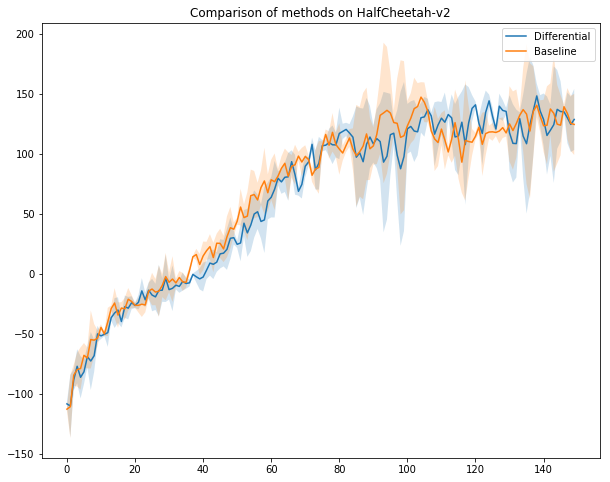

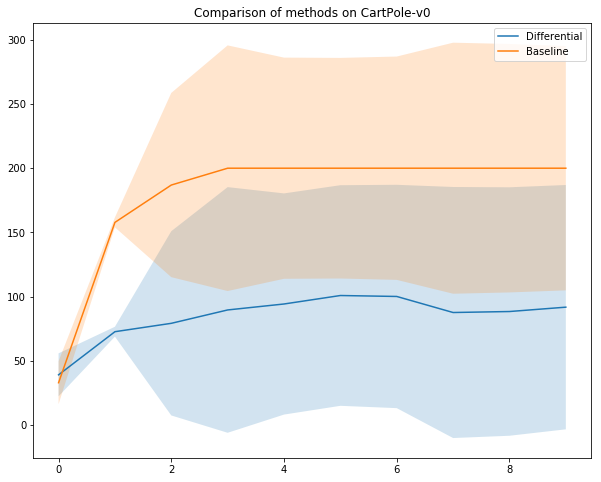

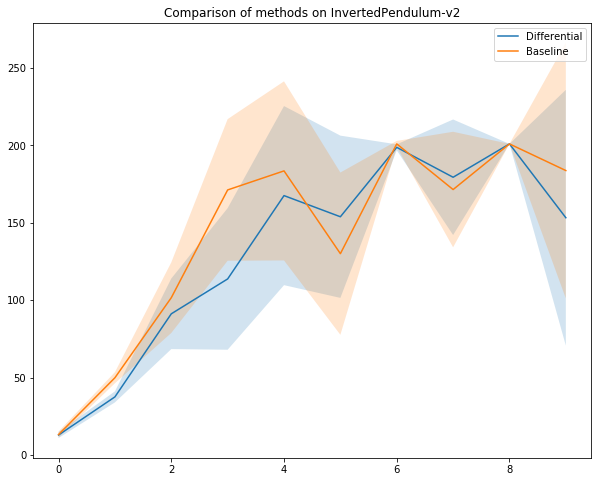

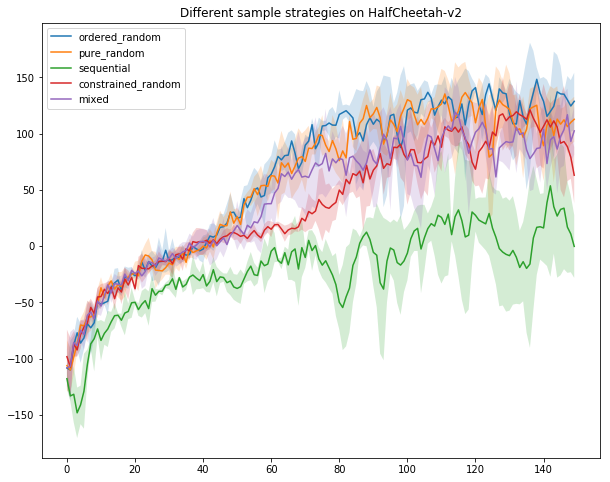

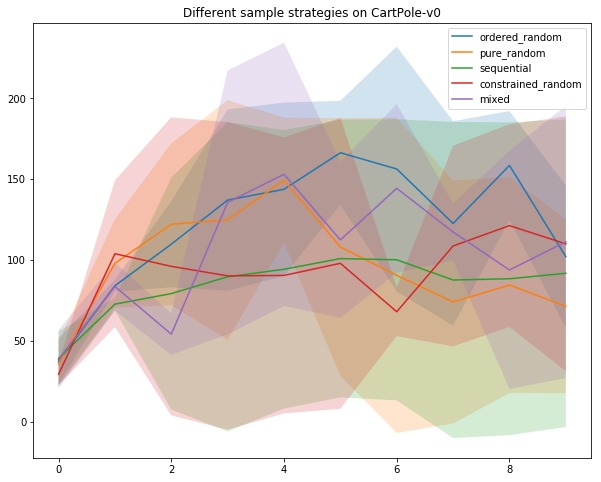

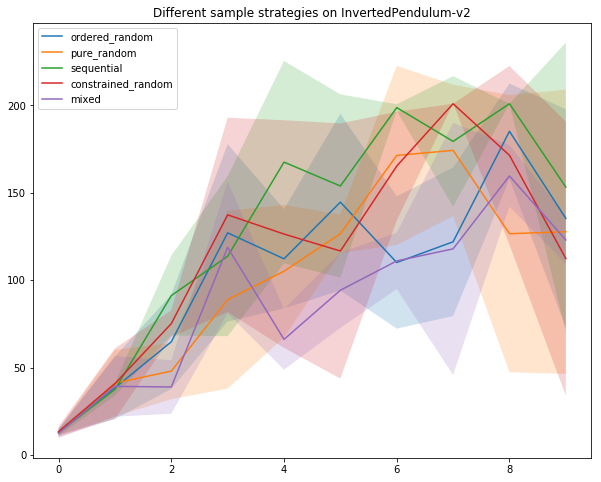

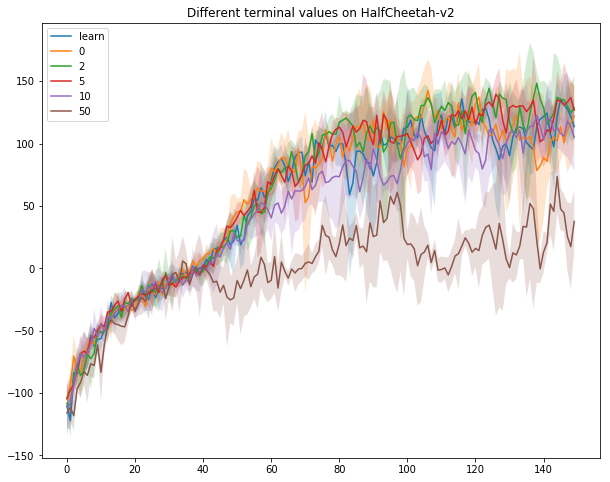

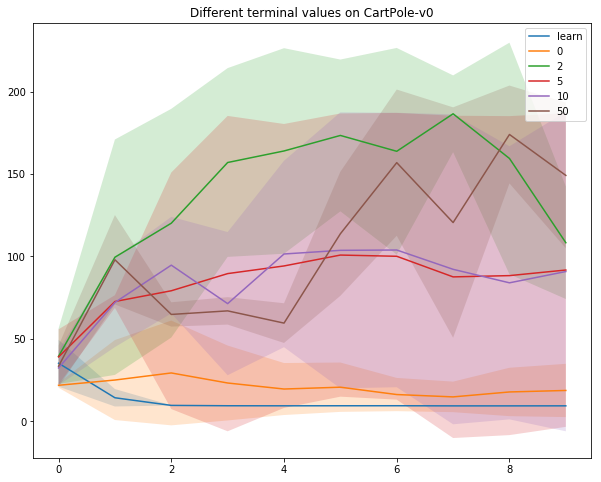

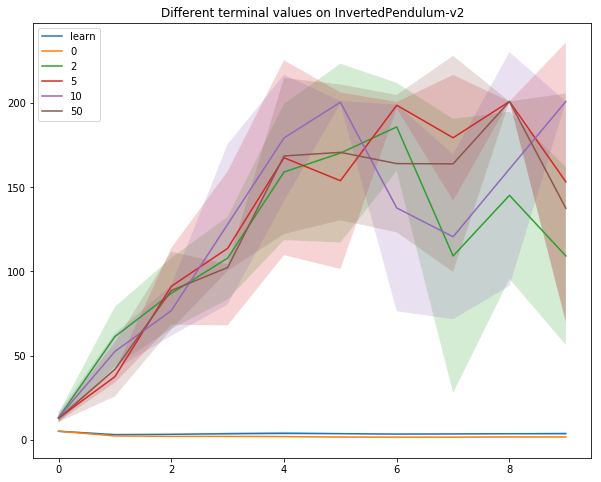

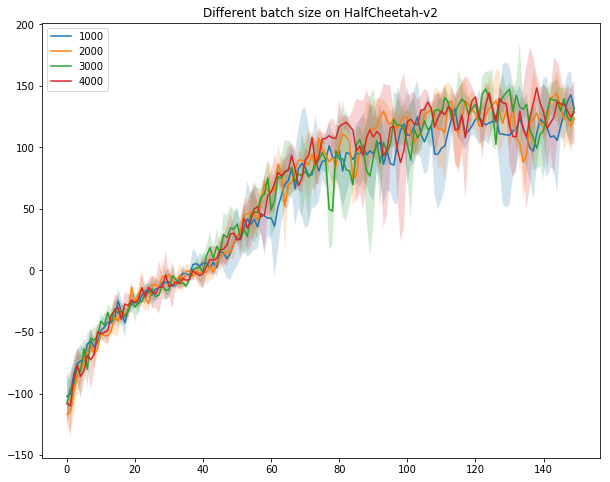

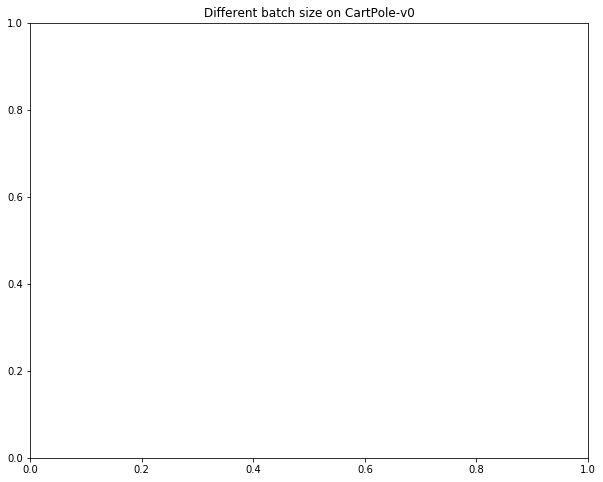

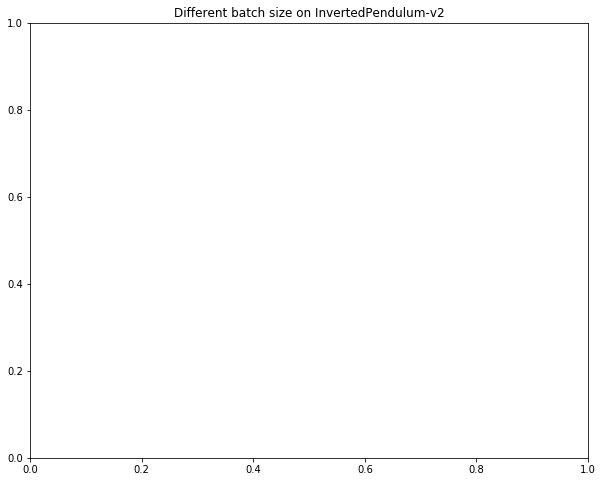

In [12]:
plot_exp_set('env_sweep', plot_baseline=True)
plot_exp_set('sample_sweep')
plot_exp_set('terminal_val_sweep')
plot_exp_set('batch_size_sweep')